# Generic notebook for common data analysis tasks

(c) Michael Neumann, Vikram Ramanarayanan, Hardik Kothare; Modality.AI, Inc., 2025

# Initial setup, imports, global settings, etc.

In [9]:
CONFIG_FILE = 'als_analysis_config.cfg'
import os

if not os.path.exists(CONFIG_FILE):
    print('ERROR: The provided config file does not exist')

In [10]:
#from sklearnex import patch_sklearn
#patch_sklearn()

import ast
from collections import defaultdict
import configparser
import copy
import datetime
import itertools
import json
import logging
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
#import piecewise_regression
import pprint
import os
# [Michael] commented out skll because it requires an old version of sklearn, i.e. this should probably be used in a separate python environment
#from skll import experiments
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import sys
import re
# note from Michael, 2021-09-24: On my new M1 Mac I had trouble with rpy2, this solved it: https://githubmemory.com/repo/rpy2/rpy2/issues/755
# note from Vikram, 2021-12-30: Make sure you have R installed on your machine: https://cran.r-project.org/bin/macosx/
# also install the "effsize" package by typing "R" on the command line to enter the R CLI and then typing "install.packages("effsize")"
# Additional note: to install "rpy2", "conda install rpy2" worked better than "pip install rpy2" 
# potentially because libraries paths were updated properly in the conda environment in the earlier method.
# update [2023-01-20] Within the conda environment, R packages can be installed using conda, e.g.: `conda install r-ROCR`
# note from Hardik/Michael [2023-07-06]: setting up rpy2 on an M2 MacBook did not work with the method above when using Anaconda as Python environment, but it worked well with miniconda
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from pprint import pformat

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import shap

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import utils as sk_utils
import sklearn.metrics as scoring_metrics

import warnings

import analysis_utils as utils

effsize = importr('effsize')
cohen_d = robjects.r['cohen.d']

# load ipython R extension ("RMagics")
%load_ext rpy2.ipython

# taken from https://stackoverflow.com/questions/45214801/how-to-make-a-large-figure-in-a-jupyter-notebook-cell-scrollable-when-it-is-out
from IPython.display import display, HTML
style = """
<style>
div.output_area {
    overflow-y: scroll;
}
div.output_area img {
    max-width: unset;
}
</style>
"""
HTML(style) 
# from https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser 
display(HTML("<style>.container { width:100% !important; }</style>"))

# parse config file
config = configparser.ConfigParser()
conf_file = config.read(CONFIG_FILE)
print(f"Loaded config file {conf_file}")
# create output directory if it doesn't exist
if not os.path.exists(config['DEFAULT']['output_dir']):
    os.mkdir(config['DEFAULT']['output_dir'])

# set up logging
logging.basicConfig(filename=f"{config['DEFAULT']['output_dir']}/analysis.log",
                    level=logging.INFO,
                    format='%(asctime)s [%(levelname)s]:%(message)s')
# the following sets up the logger to write everything to the log file AND to stdout, i.e. immitate the print statement
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
# from https://github.com/intel/scikit-learn-intelex/issues/635 [2022-11-09], only relevant if sklearnex (intel acceleration) is used
logging.getLogger().addFilter(lambda record: 'running accelerated version on CPU' not in record.msg)

# import project specific utilities
import importlib.util
spec = importlib.util.spec_from_file_location('project_utils', config['DEFAULT']['utils_package'])
project_utils = importlib.util.module_from_spec(spec)
sys.modules['project_utils'] = project_utils
spec.loader.exec_module(project_utils)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loaded config file ['als_analysis_config.cfg']


# Load and preprocess data

In [11]:
# load and preprocess data
DATA = utils.load_and_preprocess_data(config)

# project specific preprocessing is done is this function; every project_utils package should implement this function (in the trivial case of no preprocessing, it can simply return the dataframe)
DATA = project_utils.preprocess_demographics_and_diagnostics_information(DATA, config)

# Every project_utils must implement this assign_cohort function. In the simplest case, it returns the demo_patient_flag and an appropriate cohort name
DATA['demo_cohort'] = DATA.apply(lambda x: project_utils.assign_cohort(x, config)[0], axis=1)
DATA['demo_cohort_name'] = DATA.apply(lambda x: project_utils.assign_cohort(x, config)[1], axis=1)

# after preprocessing and assigning cohorts, drop NaNs in demo_cohort (this can happen if required information for assigning cohorts is not available)
#DATA = DATA.dropna(subset=['demo_cohort'])

# [Michael, 2023-03-20] I'm trying this workaround to use project-specific functions that might be not defined in other project modules
# the function `dir(modulename)` lists all names of functions and variables that are defined in the module
if 'adapt_cohort_assignments' in dir(project_utils):
    DATA = project_utils.adapt_cohort_assignments(DATA, config)

if 'session_ids_for_analysis' in config['data']:
    print(f"Using only the session IDs provided in {config['data']['session_ids_for_analysis']} for analysis!")
    session_ids_to_use = []
    with open(config['data']['session_ids_for_analysis'], 'r') as infile:
        for line in infile.readlines():
            session_ids_to_use.append(line.strip())
    DATA = DATA.loc[session_ids_to_use]
utils.summarize_data(DATA)


TypeError: expected string or bytes-like object

In [ ]:
session_ids_with_visit_name = [
	'0c2b6a50-d63a-4a22-9ae8-a14c1925856a',
	'c9c34bb3-c9e0-42e5-a0e2-aa433e541655',
	'8b181de0-08fc-43b6-84a0-14938b90bae9',
	'2ab2bbac-5a4f-4ad5-b822-d175841edc8b',
	'51e14bd5-22f6-48c6-91d7-29ea4725104e',
	'ae8a437b-9a63-4e42-841b-5c8c83401f38',
	'2cc7f8c1-c722-4c08-8014-6fc2f7cce25a',
	'2ffadd21-336e-4125-8e50-fc9f871456ac',
	'091d23ed-cbf0-438a-9607-f840cc90e40f',
	'81b6ad55-4136-4167-be2a-48bc780ecb93',
	'afe599fd-08ee-4792-8a69-1d2ce260ee4e',
	'973d8684-5beb-44db-b35e-077981039cb6',
	'f9de36f2-b1e4-4944-80bc-63807f092224',
	'2baba880-8872-4cb9-a66e-7c575bdf291e',
	'fa6169db-67e7-44f9-8c7a-6b89c47dd9d6',
	'cb04dc1e-2585-4356-b875-a232e4f85425',
	'78d132bb-199e-4e60-bd7e-ba4f745cf75c',
	'a644dc9c-a5ab-4176-80df-6336466be0c4',
	'af31550f-6e4b-4f5b-a3b7-322ef6649068',
	'e6bddc8a-df08-4115-964a-12d7d3eb91e4',
	'cce03ed6-c375-4917-b138-e21dfd85c440',
	'add239d2-1f02-4290-9008-0e37b4f6878c',
	'5d43d76a-2767-446e-a222-92685d2dddf2',
	'4c4a3f27-f6d6-4e8f-b4d9-e3cc42f100a0',
	'75948378-16ca-46f0-9a0c-f43cd7dab7d2',
	'b3ebb3a7-324e-4e4f-99c3-572ceb445f87',
	'f8e5092b-78f1-4d95-b3b6-072f35a87138',
	'f057306f-e130-4032-85d6-fbade113eee4',
	'a3f934cf-9f59-4920-97a3-425b780f17be',
	'e8773d24-f008-4ef3-b1d8-f9dae169e13a',
	'd4464ca4-b19c-4586-b1d1-59a0f84cea28',
	'965ee364-a287-4278-b60d-6ab350ac6ffd',
	'605e3857-3bcc-47af-bb58-bbeef49ec0dd',
	'24dcab36-add9-4b55-bf14-8ae23a0838cf',
	'97c2182f-1be2-48f3-83c5-551726db7a26',
	'5d31563b-bfe2-423f-a540-7ac9c1f8ba2b',
	'3b53f1ba-664d-4cbb-b982-7fa5628f0fda',
	'1a6680bd-4352-42c4-8c57-998ed219d5e5',
	'c74e4795-f7e4-4686-b3dc-b183f20f4a4e',
	'ef6cfb98-5046-4a0d-a143-33489aeea0dd',
	'7c633d47-9f54-4285-96cc-478701d9d4ac',
	'da7f3136-c208-4e36-b832-3fe806e0f640',
	'b4e21c84-7323-4834-981a-270b1549dcf1',
	'7fd610ad-1890-4183-8e19-1d9b75538778',
	'68c102db-82a6-4a0f-83a1-138a5f7e95a1',
	'7a4bfcd6-a2fe-4b61-8d6a-a55451e294d4',
	'3f344fbd-691d-4b14-b167-a0c48f46b8e6',
	'e7c6bfed-960e-4896-a8d8-00665000405b',
	'00b04323-47ea-44e3-a189-c462331adf43',
	'60a8c07f-87b8-4f85-8441-a7eb47349e04',
	'462de56c-24da-485a-b63a-4c6a46b28e08',
	'9355f460-287f-4f3c-ab5a-1d51957dfb59',
	'd43487e3-44fc-4e1c-9dae-6dd785b265a4',
	'74827cd5-f80b-4ae5-b3a2-eafc0cd0e832',
	'69ed94e3-af93-43e7-8e78-1992f95de462',
	'3434bdac-48fd-4bfb-948d-0d22db99eeac',
	'994ceedd-3921-4cde-af00-040126ec38e0',
	'3957096f-316e-4563-b8a2-549eafefec30',
	'7c184a48-9a3b-4a2c-81f0-9212f0a10f01',
	'7282eb17-3d1a-4030-a6e2-edd7257efb4f',
	'f9d36d03-2231-4782-896b-51154a37c2ff',
	'a69547e7-fab8-4c48-a4c1-763cf5a46ff5',
	'5ef859bd-9932-4d0e-a89a-366d5a9a2837',
	'9e596836-2de7-4364-8f36-6ad95de8c15c',
	'ed53a91e-14e5-4bc5-8ba2-7a098f0fb26a',
	'0d90fded-dd8b-4e75-bf6a-35359c7012d7',
	'7417b238-bb27-463e-9ea1-575840843053',
	'a4674822-e91d-4e67-af4d-3ad4479cb0bd',
	'2a6ec620-bb2d-4ea9-9144-bcceeaab5071',
	'9bcfb861-178b-407a-9197-ef406d727142',
	'52d4d5c1-6609-4404-8c16-91d3f167d136',
	'e6fc31c4-c12f-4319-af91-76bd8f610a7b',
	'226aca1c-8c09-411a-ad56-75564d43934a',
	'df036eac-0abe-4b51-b127-1244c27016cb',
	'64ffb93c-54f1-4631-8f54-f609962d4dc4',
	'1730ff2c-8384-4f5a-adf7-dc3d83e487ac',
	'f37aec50-3489-4cc0-bd2f-f509f234977f',
	'd06b8f67-8223-4d84-b37b-6fc04812f562',
	'c7ee4bc0-e288-4ff2-8d8e-dfa3c239c4f5',
	'c05edba1-1c72-4aef-8a88-83ccee2491f4',
	'544155f8-770b-4e24-87ea-6bd5fbf4b4a2',
	'8506822e-b4d5-424a-a539-5b365c8aae3c',
	'c35ea1c5-fc0d-47a0-9bc8-c7c45fb0676c',
	'639d8fbf-bab1-4a2c-8808-032ae7dccfce',
	'188d2f10-c1f5-46e6-86cb-f3aca72add1d',
	'04cf1ae4-a2d5-4406-a050-61b2857761ae',
	'61471685-bd9d-436d-8a67-0775320f21a0'
]

In [ ]:
prolific_sessions_to_include = [
    'db823069-2b5e-4c20-a4d5-88bd99bd04d2',
    'a9c4eb06-bf17-49e6-a9f3-f6691259f9d8',
    '8c304950-16db-4f54-9da6-aa7335eb4a12',
    'c5348b3f-c49a-4259-bcab-a59303fbd7de',
    'c1b4d8f9-c93c-4266-ac47-20f45f54026d',
    '4713ab30-fd4f-4058-bd17-a4f58fba995e',
    '22532b05-6ea6-4838-a120-6c17045af238',
    '55b02919-a2f2-4d5d-b520-7908287f7319',
    'ab4b7266-cbd5-45b1-9460-fed278504816',
    'bcc72dfd-1b52-428f-9f33-51ec20fe5134',
    'd0ba6c46-d074-4dd7-a003-8b6e696b2726',
    'b5d5552c-204d-4730-8f1a-d0ea2e8e19f6',
    '3a1d51c4-1eb0-4d78-8de9-96471f9cec70',
    'de4b22fa-0393-47c4-bb34-f3bd8af88e80',
    '81d72ab9-22b2-42df-a7cb-f77c1fb91052',
    '2e00ce55-d7b1-4cfd-aea9-b155b569b26e',
    '97131020-543c-45fc-896f-a2f81b93f437',
    '0e0095d4-38ee-45b6-94fb-14986c1fed34',
    'e3fabcbb-080d-4ac5-a3b8-772b35c4bca7',
    '349df844-36d0-4295-86aa-a98e2837a1cc',
    '8666f701-daed-40e8-a874-3eec7c6c486f',
    '57c43ff2-9043-49b5-9ed6-d2f41234e070',
    'f199bf73-c443-456c-a8a5-0e292c333cb1',
    '776e9d0d-57b8-4497-ab21-a1b662aec472',
    'adad39c0-a115-454a-8f7c-f49dbf96cdc8',
    'a9bc1878-d121-441b-b597-88d1f07010b0',
    '47fdb1ef-dbc0-4eeb-adcb-f26791e8bd4d',
    'b9c9e7f5-46d6-4ac6-9879-97fd55f7d1a9',
    'c283efc8-effa-4027-b201-832529bfaa96',
    '110dcf9a-1cf7-4c5a-8d61-fd7c73f0b726',
    '8452c390-c7fb-45a5-9445-3af541fef807',
    '7918b64e-24b9-440a-b7fa-4b9aac393dae',
    '724cf715-0c1b-414e-8cbf-1f3d7ef04eb8',
    'fd29d5f8-303f-4bd8-83f2-442466100442',
    '19b7e68c-b886-4429-b6b4-24be2c743f6b',
    '3253789e-47c9-4ebc-a600-ed62d732f61c',
    '8e615829-f98c-47d0-960b-9382c910c00d',
    '940ddadf-dce5-49ac-8003-dfbe02b3fee0',
    '7b9c9eea-7d87-49e6-9949-9a495c807772',
    'c253511a-e95d-4e99-afca-c8e256b273d8',
    '71a1d463-8ff5-42eb-9acd-e448816085b1',
    '3c27c31c-83ce-46a2-8960-d7e98a0f62fd',
    '4b263599-5443-4cea-b429-a1de9363f4ee',
    '1ba9a6f3-dd20-4fcf-8c34-9f2e918f9e03',
    'e2096f45-236f-4354-813a-8f68e07240ee',
    '80b174f7-cd91-4080-91bd-80c5a3ce051a',
    '1881b717-37a9-48f0-a684-bc965ab75c75',
    '0af1c795-c791-455f-9ebd-5013432a2975',
    '9b60c52a-781c-4ac3-ae05-7c10ca9d25ce',
    'a3988970-cd0c-4d5f-80f8-5bec2c3a865b',
    '49e0ae64-9514-4635-a8f0-5bbeea29acb1',
    '8377af1b-c8b7-4cc4-a19a-01b79a336954',
    'ad2c5781-672f-4bf5-a220-80227c8c9dee',
    '4e736ca5-892c-4aee-9c0b-0cdaa28723ff',
    '90909fbd-c60a-43a5-92cd-af411e10525e',
    'd27e23c5-e6f4-4e9d-bdaa-ef5853ecd25e',
    '2477fa1e-b477-4097-bfc3-398003a0871d',
    '8b22b518-090f-40db-a129-b7dc85dd1cf5'
]

In [ ]:
DATA = DATA[(DATA.index.isin(session_ids_with_visit_name + prolific_sessions_to_include))] # | (DATA['session_info_access_code']=='88d1oq')]
utils.summarize_data(DATA) #[DATA['demo_patient_flag'] == 0])

## If desired, reduce the dataset to a balanced version with age and sex matched controls

In [ ]:
# # This assumes that we have more controls than patients in the DATA
# # The following parameters can be changed as needed for the individual project:
# SEX_MATCHED = True
# AGE_MATCHED = True
# AGE_TOLERANCE = 3  # how many years tolerance is accepted in case no exact age-match is found

# if 'use_balanced_data' in config['data']:
#     if config['data'].getboolean('use_balanced_data'):
#         patient_ids = DATA[DATA['demo_patient_flag']==1]['session_info_access_code'].sort_values().unique()
#         selected_control_ids = utils.select_controls(
#             DATA,
#             patient_ids,
#             sex_matched=SEX_MATCHED,
#             age_matched=AGE_MATCHED,
#             age_tolerance=AGE_TOLERANCE
#         )
#         DATA = DATA[DATA['session_info_access_code'].isin(selected_control_ids + list(patient_ids))]
#         utils.summarize_data(DATA)
#     else:
#         logging.info('Config option "use_balanced_data" is False')
# else:
#     logging.info('No config option "use_balanced_data" found in config')

# Compute linguistic features

This should go into analysis_utils.py eventually

#### Define function to compute linguistic features

Make sure you run:

$ python3 -m spacy download en_core_web_sm

in the command line before loading spacy models. 

In [ ]:
# SpeechGraph features

from collections import Counter
import re
import networkx as nx
import spacy

class _graphStatistics():

    def __init__(self,graph):
        self.graph= graph

    def statistics(self):
        res ={}
        graph = self.graph
        if graph.number_of_nodes() == 0 and graph.number_of_edges() == 0:
            return {
                'num_nodes': 0,
                'num_edges': 0,
                'PE': np.nan,
                'LCC': np.nan,
                'LSC': np.nan,
                'degree_avg': np.nan,
                'degree_std': np.nan,
                'L1': np.nan,
                'L2': np.nan,
                'L3': np.nan
            }
        res['num_nodes'] = graph.number_of_nodes()
        res['num_edges'] = graph.number_of_edges()
        res['PE'] =  (np.array(list(Counter(graph.edges()).values()))>1).sum()
        res['LCC'] =  nx.algorithms.components.number_weakly_connected_components(graph)
        res['LSC'] =  nx.algorithms.components.number_strongly_connected_components(graph)

        #degrees = list(graph.degree().itervalues())
        degrees = [degree for node, degree in graph.degree()]

        res['degree_avg'] =  np.mean(degrees)
        res['degree_std'] =  np.std(degrees)


        #adj_matrix = nx.linalg.adj_matrix(graph).toarray()
        adj_matrix = nx.adjacency_matrix(graph).toarray()
        adj_matrix2 = np.dot( adj_matrix , adj_matrix)
        adj_matrix3 = np.dot( adj_matrix2 , adj_matrix)

        res['L1'] =  np.trace(adj_matrix)
        res['L2'] =  np.trace(adj_matrix2)
        res['L3'] =  np.trace(adj_matrix3)

        return res


class naiveGraph():
    def __init__(self, spacy_model="en_core_web_sm"):
        self.nlp = spacy.load(spacy_model)

    def _text2graph(self, text):
        doc = self.nlp(text)
        words = [token.text for token in doc if not token.is_punct and not token.is_space]
        gr = nx.MultiDiGraph()
        gr.add_edges_from( zip(words[:-1], words[1:]))
        return gr

    def analyzeText(self, text):
        dgr = self._text2graph(text)
        return _graphStatistics(dgr).statistics()
    
    def drawGraph(self, text):
        graph = self._text2graph(text)

        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph, k=2.5)  # Positions for all nodes

        #nx.draw(graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold", arrows=True)
        nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=500)  # Smaller nodes
        nx.draw_networkx_edges(graph, pos, edge_color="gray", alpha=0.5, width=0.5)  # Transparent edges
        nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold", verticalalignment='bottom')  # Rotate labels

        plt.title("Speech Graph Visualization")
        plt.show()

class stemGraph():

    def __init__(self, spacy_model="en_core_web_sm"):
        self.nlp = spacy.load(spacy_model)

    def _text2graph(self, text):
        doc = self.nlp(text)
        lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
        gr = nx.MultiDiGraph()
        gr.add_edges_from( zip(lemmas[:-1], lemmas[1:]))
        return gr

    def analyzeText(self, text):
        dgr = self._text2graph(text)
        return _graphStatistics(dgr).statistics()

class posGraph():

    def __init__(self, spacy_model="en_core_web_sm"):
        self.nlp = spacy.load(spacy_model)

    def _text2graph(self, text):
        doc = self.nlp(text)
        pos_tags = [token.pos_ for token in doc if not token.is_punct and not token.is_space]
        gr = nx.MultiDiGraph()
        gr.add_edges_from( zip(pos_tags[:-1], pos_tags[1:]))
        return gr

    def analyzeText(self, text):
        dgr = self._text2graph(text)
        return _graphStatistics(dgr).statistics()
    
    def drawGraph(self, text):
        graph = self._text2graph(text)

        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph, k=2.5)  # Positions for all nodes

        #nx.draw(graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold", arrows=True)
        nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=500)  # Smaller nodes
        nx.draw_networkx_edges(graph, pos, edge_color="gray", alpha=0.5, width=0.5)  # Transparent edges
        nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold", verticalalignment='bottom')  # Rotate labels

        plt.title("Speech Graph Visualization")
        plt.show()
    
def compute_speech_graph_features_from_text(text, spacy_model="en_core_web_sm"):
    ngraph_feats = naiveGraph(spacy_model=spacy_model).analyzeText(text)
    sgraph_feats = stemGraph(spacy_model=spacy_model).analyzeText(text)
    pgraph_feats = posGraph(spacy_model=spacy_model).analyzeText(text)
    ngraph_feats = {f"ngraph_{key}": value for key, value in ngraph_feats.items()}
    sgraph_feats = {f"sgraph_{key}": value for key, value in sgraph_feats.items()}
    pgraph_feats = {f"pgraph_{key}": value for key, value in pgraph_feats.items()}    
    # {'num_nodes': 2, 'num_edges': 1, 'PE': 0, 'LCC': 1, 'LSC': 2, 'degree_avg': 1.0, 'degree_std': 0.0, 'L1': 0, 'L2': 0, 'L3': 0}
    combined_values = [value for d in (ngraph_feats, sgraph_feats, pgraph_feats) for value in d.values()]
    return combined_values



In [ ]:
text = 'The quick brown fox jumps over the lazy dog.'
# Example usage
pos_graph = posGraph(spacy_model="en_core_web_sm")
pos_graph.drawGraph(text)
print(pos_graph.analyzeText(text))

text = 'El rápido zorro marrón salta sobre el perro perezoso.'
# Example usage
pos_graph = posGraph(spacy_model="es_core_news_sm")
pos_graph.drawGraph(text)
print(pos_graph.analyzeText(text))

In [ ]:
from collections import Counter
from empath import Empath
import math

def get_num_repetitions(pro) -> int:
    """
    # immediate repetitions of words
    """
    tokens_without_commas = [item for item in pro if item.text != ',']
    repetition_count = 0
    for i in range(1, len(tokens_without_commas)):
        if tokens_without_commas[i].is_alpha or tokens_without_commas[i].is_digit:
            lower_i = tokens_without_commas[i].text.lower()
            lower_im1 = tokens_without_commas[i - 1].text.lower()
            if lower_i == lower_im1:
                repetition_count += 1
    return repetition_count

def get_honore_and_brunet(text) -> float:
    """
    100logN/(1−V1/V);
    N = # word tokens,
    V1  = # words used once in the text,
    V = # word types
    """
    tokens = [token.text.lower() for token in text if token.is_alpha]
    N = len(tokens)
    freq_dist = Counter(tokens)
    V = len(freq_dist)
    V1 = sum(1 for count in freq_dist.values() if count == 1)
    if V == 0 or (1 - V1 / V) == 0:  # Avoid division by zero
        R = np.nan
    else:
        R = (100 * math.log(N)) / (1 - V1 / V)
    brunet = N ** (V ** (-0.165)) if V > 0 else np.nan
    return R, brunet

def tree_height_rec(sentence_root):
    """
    recursive helper for tree_height
    * uses Spacy
    """
    if not list(sentence_root.children):  # no children hence empty list
        return 0
    else:
        depth = 1

        depth_list = []

        for token in list(sentence_root.children):
            depth_list.append(tree_height_rec(token))

        return depth + max(depth_list)

def tree_height(pro):
    """
    height of each parse tree,
    averaged over all sentences; the height of a tree
    is the number of edges on the longest downward
    path between the root and a leaf
    * uses Spacy
    """
    sentence_height_list = []

    for sentence in pro.sents:
        sentence_height_list.append(tree_height_rec(sentence.root))

    return sum(sentence_height_list) / len(sentence_height_list)

def compute_linguistic_features_from_text(transcript, spacy_model="en_core_web_sm"):
    '''
    Function that takes in a text string of a transcription
    and computes lexico-semantic and sentiment features, 
    returning them as a list.
    
    index = 0 by default. Can pass in a DataFrame index if applying on a DataFrame
    '''
    
    # Define Part of Speech (POS) -> Content/Function word mapping
    # See complete list of SPACY.IO tags here: https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
    content_EnglishPOS = ["CD", 
               "JJ", "JJR", "JJS",
               "MD", 
               "NN", "NNP", "NNPS", "NNP",
               "RB","RBR","RBS", "RP",
               "VB", "VBD", "VBG", "VBN", "VBP", "VBZ",
               "WRB"]
    content_words_pos = ["ADJ", "ADV", "NOUN", "NUM", "PROPN", "SYM", "VERB"]
    function_words_pos = ["ADP","AUX","CONJ","CCONJ","DET","INTJ","PART","PRON","SCONJ"]
    others = ["PUNCT","X","EOL","SPACE"]
    

    #Load in the SPACY library/models 
    nlp = spacy.load(spacy_model)

    if isinstance(transcript, pd.Series):
        line = transcript.str.rstrip()
        logging.info(line)
        text = nlp(line.str)
        wordCount = len(line.str.split())
    else:
        line = transcript.rstrip()
        #print(line)
        text = nlp(line)
        wordCount = sum(1 for token in text if (not token.is_punct and not token.is_space))
        
#     line = transcript.rstrip()
#     print(line)
#     text = nlp(line)
#     wordCount = len(line.split())
    #print("Word Count: " + str(wordCount))

    ###### I. CONTENT VS. FUNCTION words analysis ######
    # ------------------------------------------------ #

    # print(contentWordCount)
    contentWordCount = 0
    functionWordCount = 0
    for token in text:
    # print(token.text, " : ", token.pos_)
    # print(token.text, token.pos_, token.dep_)
        if token.pos_ in content_words_pos:
            contentWordCount += 1
        if token.pos_ in function_words_pos:
            functionWordCount += 1

    # print(contentWordCount/wordCount)
    pctContentWords = contentWordCount / (contentWordCount + functionWordCount)
    #print("% of content words: " + str(pctContentWords))
    # spacy.displacy.serve(text, style="dep")


    ###### II. Extract LEXICO-SEMANTIC features ######
    ###### ------------------------------------ ######
    #
    # Reference: Boschi et al. (2017, Front. Psych.)
    # https://www.frontiersin.org/articles/10.3389/fpsyg.2017.00269/full

    # #Combine the following 3 lines into one line below:
    # nounCount = sum([1 for token in text if token.pos_=="NOUN"])
    # nounRate = nounCount/wordCount
    # # print(nounCount)
    
    nounRate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["NOUN", "NUM", "PROPN"])/wordCount
    verbRate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["VERB", "AUX"])/wordCount
    pronounRate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["PRON"])/wordCount
    noun_verb_ratio = np.nan if (verbRate == 0 or np.isnan(verbRate)) else sum(1 for token in text if token.pos_ in ["NOUN","NUM","PROPN"]) / sum(1 for token in text if token.pos_ in ["VERB","AUX"]) 
    noun_pronoun_ratio = np.nan if (pronounRate == 0 or np.isnan(pronounRate)) else sum(1 for token in text if token.pos_ in ["NOUN", "NUM", "PROPN"]) / sum(1 for token in text if token.pos_ in ["PRON"]) 
    closed_class_word_ratio = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in function_words_pos)/wordCount
    idea_density = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["VERB", "ADJ", "ADV", "ADP", "CONJ", "CCONJ", "SCONJ"]) / wordCount
    demonstrative_rate = np.nan if wordCount == 0 else sum(1 for token in text if token.text.lower() in ["this", "that", "these", "those"])/wordCount
    adjective_rate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["ADJ"])/wordCount
    adverb_rate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["ADV"])/wordCount
    conjunction_rate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in ["CONJ", "CCONJ", "SCONJ"])/wordCount
    possessive_rate = np.nan if wordCount == 0 else sum(1 for token in text if token.dep_ in ["poss"])/wordCount
    noun_ratio = np.nan if contentWordCount == 0 else sum(1 for token in text if token.pos_ in ["NOUN", "PROPN"]) / contentWordCount
    open_class_word_rate = np.nan if wordCount == 0 else sum(1 for token in text if token.pos_ in content_words_pos)/wordCount
    repetitions = get_num_repetitions(text)
    honores_R, brunets_index = get_honore_and_brunet(text)

    tokens = [token.text.lower() for token in text if token.is_alpha]
    freq_dist = Counter(tokens)
    V = len(freq_dist)
    type_token_ratio = np.nan if wordCount == 0 else V / wordCount
    total_characters = sum(len(token) for token in tokens)
    average_word_length = np.nan if wordCount == 0 else total_characters / wordCount

    ###### Discourse and pragmatic features ########
    num_subjects = sum([1 for token in text if token.dep_ in ["nsubj", "nsubjpass"]])
    num_objects = sum([1 for token in text if token.dep_ in ["dobj", "pobj", "obj"]])    
    num_places = len(text.ents)

    ###### Morphosyntactic features ########
    num_verbs = sum([1 for token in text if token.pos_ in ["VERB", "AUX"]])
    if num_verbs == 0:
        inflected_verb_rate = np.nan
        gerund_rate = np.nan
        light_verb_rate = np.nan
    else:
        inflected_verb_rate = sum([1 for token in text if (token.pos_ in ["VERB", "AUX"] and token.tag_ in ["VBD", "VBG", "VBZ", "VBN"])]) / num_verbs # don't include VBP because it doesn't show morphological changes in English
        gerund_rate = sum([1 for token in text if (token.pos_ in ["VERB", "AUX"] and token.tag_ in ["VBG"])]) / num_verbs
        light_verb_rate = sum([1 for token in text if (token.pos_ in ["VERB", "AUX"] and token.lemma_ in ["be", "have", "come", "go", "give", "take", "make", "do", "get", "move", "put"])]) / num_verbs

    ###### Syntactic features ########
    avg_tree_height = tree_height(text)


    ###### III. Analyze word topics using EMPATH (an alternative to LIWC) ######
    # ------------------------------------------------------------------------ #
    # # Code: https://github.com/Ejhfast/empath-client 
    # # Paper: https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf

    if spacy_model != "en_core_web_sm":
        sentiment_pos = np.nan
        sentiment_neg = np.nan
    else:
        lexicon = Empath()
        sentiment = lexicon.analyze(line, categories=["negative_emotion", "positive_emotion"], normalize=True)
        sentiment_pos = sentiment["positive_emotion"]
        sentiment_neg = sentiment["negative_emotion"]

    return wordCount, pctContentWords, nounRate, verbRate, pronounRate, noun_verb_ratio, noun_pronoun_ratio, closed_class_word_ratio, idea_density, sentiment_pos, sentiment_neg, demonstrative_rate, adjective_rate, adverb_rate, conjunction_rate, possessive_rate, noun_ratio, open_class_word_rate, repetitions, honores_R, brunets_index, type_token_ratio, average_word_length, num_subjects, num_objects, num_places, num_verbs, inflected_verb_rate, gerund_rate, light_verb_rate, avg_tree_height



In [ ]:
# Test function

transcript = 'He sells sea shells on the sea shore'
#transcript = 'Um one minute'
print(compute_linguistic_features_from_text(transcript, spacy_model="en_core_web_sm"))

transcript = 'El rápido zorro marrón salta sobre el perro perezoso.'

print(compute_linguistic_features_from_text(transcript, spacy_model="es_core_news_sm"))

In [ ]:
print([col for col in DATA.columns if 'transcription' in col])

In [ ]:
# if 'project_code_to_spacy_model' in config['data']:
#     project_code_to_spacy_model = ast.literal_eval(config['data']['project_code_to_spacy_model'])
# else:
#     print('No project_code_to_spacy_model mapping found in config file, using default SpaCy model "en_core_web_sm"')
#     project_code_to_spacy_model = {project_code: "en_core_web_sm" for project_code in DATA['session_info_project_code'].unique()}
# print(project_code_to_spacy_model)

# for prompt in ['PictureDescription']:
# # for prompt in ['SpontaneousSpeech', 'PictureDescription']: #StoryRetells
#     transcripts = DATA[[f'text_metrics_{prompt}_transcription', 'session_info_project_code']]

#     feature_list = ["WordCount", "PctContentWords", "NounRate", 
#                     "VerbRate", "PronounRate", "NounVerbRatio", 
#                  "NounPronounRatio", "ClosedClassWordRatio", "IdeaDensity", 
#                  "EMPATHPositiveCosineSimilarity", "EMPATHNegativeCosineSimilarity",
#                  "demonstrativeRate", "adjectiveRate", "adverbRate", "conjunctionRate", "possessiveRate", "nounRatio", "openClassWordRate", "repetitions", "honoresR", "brunetsIndex", "typeTokenRatio", "averageWordLength", "numSubjects", "numObjects", "numPlaces", "numVerbs", "inflectedVerbRate", "gerundRate", "lightVerbRate", "avg_tree_height"]
#     speech_graph_list = [
#         "ngraph_num_nodes",
#         "ngraph_num_edges",
#         "ngraph_PE",
#         "ngraph_LCC",
#         "ngraph_LSC",
#         "ngraph_degree_avg",
#         "ngraph_degree_std",
#         "ngraph_L1",
#         "ngraph_L2",
#         "ngraph_L3",
#         "sgraph_num_nodes",
#         "sgraph_num_edges",
#         "sgraph_PE",
#         "sgraph_LCC",
#         "sgraph_LSC",
#         "sgraph_degree_avg",
#         "sgraph_degree_std",
#         "sgraph_L1",
#         "sgraph_L2",
#         "sgraph_L3",
#         "pgraph_num_nodes",
#         "pgraph_num_edges",
#         "pgraph_PE",
#         "pgraph_LCC",
#         "pgraph_LSC",
#         "pgraph_degree_avg",
#         "pgraph_degree_std",
#         "pgraph_L1",
#         "pgraph_L2",
#         "pgraph_L3"
#     ]
#     prefix = f'text_metrics_{prompt}_'
#     feature_list_with_prefix = [prefix + feature for feature in feature_list]
#     speech_graph_features_with_prefix = [prefix + feature for feature in speech_graph_list]

#     transcripts = transcripts.reindex(columns = transcripts.columns.tolist() + feature_list_with_prefix + speech_graph_features_with_prefix)

#     display(transcripts)

#     for i, row in transcripts.iterrows():
#         if not pd.isna(row[f'text_metrics_{prompt}_transcription']):
#             transcripts.loc[i, feature_list_with_prefix] = compute_linguistic_features_from_text(row[f'text_metrics_{prompt}_transcription'], spacy_model=project_code_to_spacy_model[row['session_info_project_code']])
#             transcripts.loc[i, speech_graph_features_with_prefix] = compute_speech_graph_features_from_text(row[f'text_metrics_{prompt}_transcription'], spacy_model=project_code_to_spacy_model[row['session_info_project_code']])


#     # Remove overlapping columns from transcripts before merging
#     transcripts = transcripts.drop(columns=[col for col in transcripts.columns if col in DATA.columns])
#     # merge the new features into the main dataframe
#     DATA = DATA.merge(transcripts, how='inner', left_index = True, right_index=True, validate="one_to_one")

# if config['data'].getboolean('aggregate_metrics_across_all_prompts'):
#     DATA = utils.aggregate_metrics(DATA, feature_list, prefix='text_metrics')

try:
    if 'project_code_to_spacy_model' in config['data']:
        model_map_str = config['data']['project_code_to_spacy_model']
        logging.info(f"Using project_code_to_spacy_model mapping from config: {model_map_str}")
        try:
            # Parse the string dictionary
            parsed_map = ast.literal_eval(model_map_str)
            # Convert string keys to integers
            project_code_to_spacy_model = {int(k): v for k, v in parsed_map.items()}
            logging.info(f"Parsed model map (int keys): {project_code_to_spacy_model}")
        except (SyntaxError, ValueError, TypeError) as e:
            logging.error(f"Error parsing 'project_code_to_spacy_model' from config: {e}. String was: {model_map_str}. Using default 'en_core_web_sm'.")
            # Fallback to default if parsing fails
            all_project_codes = DATA['session_info_project_code'].dropna().unique()
            project_code_to_spacy_model = {int(code): "en_core_web_sm" for code in all_project_codes if pd.notna(code)} # Ensure codes are int
    else:
        logging.warning('No project_code_to_spacy_model mapping found in config file. Detecting codes from data and using default SpaCy model "en_core_web_sm".')
        # Ensure project codes are treated as integers if possible
        all_project_codes = DATA['session_info_project_code'].dropna().unique()
        project_code_to_spacy_model = {int(code): "en_core_web_sm" for code in all_project_codes if pd.notna(code)} # Ensure codes are int
        logging.info(f"Created default model map: {project_code_to_spacy_model}")

except NameError:
     raise NameError("'config' or 'DATA' not defined. Run previous cells.")
except KeyError as e:
     raise KeyError(f"Error accessing config or DATA: {e}")


# Define default model if lookup fails later
DEFAULT_SPACY_MODEL = "en_core_web_sm"

# --- Feature Computation Loop ---
# Define available prompts based on previous error diagnosis
available_prompts_with_transcripts = ['PictureDescription']

logging.info(f"Processing linguistic/graph features for prompts: {available_prompts_with_transcripts}")

for prompt in available_prompts_with_transcripts:
    transcript_col_name = f'text_metrics_{prompt}_transcription'
    project_code_col = 'session_info_project_code'

    # Check if required columns exist
    if transcript_col_name not in DATA.columns or project_code_col not in DATA.columns:
        logging.warning(f"Required columns ('{transcript_col_name}', '{project_code_col}') not found in DATA. Skipping prompt '{prompt}'.")
        continue

    logging.info(f"Processing prompt: {prompt}")
    # Select initial columns and copy to avoid SettingWithCopyWarning
    transcripts = DATA[[transcript_col_name, project_code_col]].copy()

    # --- Define Feature Lists ---
    feature_list = ["WordCount", "PctContentWords", "NounRate", "VerbRate", "PronounRate", "NounVerbRatio", "NounPronounRatio", "ClosedClassWordRatio", "IdeaDensity", "EMPATHPositiveCosineSimilarity", "EMPATHNegativeCosineSimilarity", "demonstrativeRate", "adjectiveRate", "adverbRate", "conjunctionRate", "possessiveRate", "nounRatio", "openClassWordRate", "repetitions", "honoresR", "brunetsIndex", "typeTokenRatio", "averageWordLength", "numSubjects", "numObjects", "numPlaces", "numVerbs", "inflectedVerbRate", "gerundRate", "lightVerbRate", "avg_tree_height"]
    speech_graph_list = ["ngraph_num_nodes", "ngraph_num_edges", "ngraph_PE", "ngraph_LCC", "ngraph_LSC", "ngraph_degree_avg", "ngraph_degree_std", "ngraph_L1", "ngraph_L2", "ngraph_L3", "sgraph_num_nodes", "sgraph_num_edges", "sgraph_PE", "sgraph_LCC", "sgraph_LSC", "sgraph_degree_avg", "sgraph_degree_std", "sgraph_L1", "sgraph_L2", "sgraph_L3", "pgraph_num_nodes", "pgraph_num_edges", "pgraph_PE", "pgraph_LCC", "pgraph_LSC", "pgraph_degree_avg", "pgraph_degree_std", "pgraph_L1", "pgraph_L2", "pgraph_L3"]
    prefix = f'text_metrics_{prompt}_'
    feature_list_with_prefix = [prefix + feature for feature in feature_list]
    speech_graph_features_with_prefix = [prefix + feature for feature in speech_graph_list]

    # Use reindex to safely add new columns, initializing with NaN
    new_cols = feature_list_with_prefix + speech_graph_features_with_prefix
    transcripts = transcripts.reindex(columns=transcripts.columns.tolist() + new_cols, fill_value=np.nan)

    # display(transcripts.head()) # Optional: Display structure

    # --- Iterate and Compute Features ---
    logging.info(f"Computing features for {len(transcripts)} transcripts...")
    computed_count = 0
    error_count = 0
    skipped_nan_transcript = 0
    skipped_nan_proj_code = 0

    # Ensure the feature computation functions are defined/imported
    try:
         _ = compute_linguistic_features_from_text
         _ = compute_speech_graph_features_from_text
    except NameError:
         raise NameError("Functions 'compute_linguistic_features_from_text' or 'compute_speech_graph_features_from_text' are not defined.")


    for i, row in transcripts.iterrows():
        transcript_text = row[transcript_col_name]
        project_code_val = row[project_code_col]

        if pd.isna(transcript_text) or not str(transcript_text).strip():
            skipped_nan_transcript += 1
            continue # Skip if transcript is NaN or empty

        if pd.isna(project_code_val):
            logging.warning(f"Missing project code for index {i}. Using default model '{DEFAULT_SPACY_MODEL}'.")
            spacy_model_to_use = DEFAULT_SPACY_MODEL
            skipped_nan_proj_code += 1
        else:
            try:
                # Ensure project code is integer for lookup
                project_code_int = int(project_code_val)
                # Use .get() for safe dictionary lookup with a default fallback
                spacy_model_to_use = project_code_to_spacy_model.get(project_code_int, DEFAULT_SPACY_MODEL)
                if project_code_int not in project_code_to_spacy_model:
                     logging.warning(f"Project code {project_code_int} for index {i} not found in mapping. Using default '{DEFAULT_SPACY_MODEL}'.")

            except (ValueError, TypeError):
                 logging.warning(f"Could not convert project code '{project_code_val}' to integer for index {i}. Using default model '{DEFAULT_SPACY_MODEL}'.")
                 spacy_model_to_use = DEFAULT_SPACY_MODEL
                 skipped_nan_proj_code += 1 # Count as skipped due to code issue

        # Compute features
        try:
            ling_features = compute_linguistic_features_from_text(transcript_text, spacy_model=spacy_model_to_use)
            graph_features = compute_speech_graph_features_from_text(transcript_text, spacy_model=spacy_model_to_use)

            # Assign features using .loc
            transcripts.loc[i, feature_list_with_prefix] = ling_features
            transcripts.loc[i, speech_graph_features_with_prefix] = graph_features
            computed_count += 1

        except Exception as e:
            logging.error(f"Error computing features for index {i} (ProjCode: {project_code_val}, Model: {spacy_model_to_use}): {e}")
            # Features remain NaN as initialized by reindex
            error_count += 1

    logging.info(f"Finished computation for prompt '{prompt}'. Processed: {computed_count}, Errors: {error_count}, Skipped (NaN Transcript): {skipped_nan_transcript}, Skipped (Proj Code Issue): {skipped_nan_proj_code}")

    # --- Merge results back ---
    # Remove original columns from the results dataframe before merging to avoid conflicts
    cols_to_drop_before_merge = [transcript_col_name, project_code_col]
    transcripts_features_only = transcripts.drop(columns=[col for col in cols_to_drop_before_merge if col in transcripts.columns])

    # Merge the new features into the main dataframe using index
    # Ensure DATA index is set (assuming it was set earlier, e.g., to session_id)
    if DATA.index.name != transcripts_features_only.index.name and DATA.index.name == 'session_info_session_id':
         logging.warning(f"DATA index name ({DATA.index.name}) differs from transcripts index name ({transcripts_features_only.index.name}). Aligning DATA index before merge.")
         # This assumes transcripts index is correct (session_id) and DATA needs re-indexing if it lost it.
         # DATA = DATA.set_index('session_info_session_id', drop=False) # Might cause issues if index isn't unique

    # Perform a left merge to keep all rows from DATA
    try:
         # Validate ensures indices are unique, which they should be if session_id is the index
         DATA = DATA.merge(transcripts_features_only, how='left', left_index=True, right_index=True, validate="one_to_one", suffixes=('', '_DROP'))
         # Drop any columns resulting from merge conflicts if necessary (shouldn't happen with left index merge if columns were dropped)
         DATA = DATA.drop(columns=[col for col in DATA.columns if '_DROP' in col], errors='ignore')
         logging.info(f"Merged computed features for prompt '{prompt}' into DATA.")
    except Exception as merge_err:
         logging.error(f"Error merging features for prompt '{prompt}': {merge_err}")

In [ ]:
display(DATA.filter(regex='text_metrics'))

In [ ]:
# identify very short samples (< threshold_word_count) and set their features to NaN
threshold_word_count = 3

idx = DATA[DATA['text_metrics_PictureDescription_WordCount'] < threshold_word_count].index
cols = DATA.filter(regex='PictureDescription').columns.to_list()
DATA.loc[idx, cols] = np.nan
print(len(idx))

# idx = DATA[DATA['text_metrics_SpontaneousSpeech_WordCount'] < threshold_word_count].index
# cols = DATA.filter(regex='SpontaneousSpeech').columns.to_list()
# DATA.loc[idx, cols] = np.nan
# print(len(idx))

# Store preprocessed data to disk / load it from disk to start here
Because computation of linguistic features is time-consuming, it can be useful to store the data at this point, so that it can be loaded with linguistic features for future runs of the analysis.

In [ ]:
filename = 'data_preprocessed_linguistic_features_filtered_metrics.csv'
#filename = 'data_preprocessed_linguistic_features_matched_controls.csv'

if 'DATA' in globals():
    if not os.path.exists(f"{config['DEFAULT']['data_dir']}/{filename}"):
        DATA.to_csv(f"{config['DEFAULT']['data_dir']}/{filename}")
    else:
        print('Did not write the contents to file because such a file with that filename already exists')
else:
    DATA = pd.read_csv(f"{config['DEFAULT']['data_dir']}/{filename}",
                       index_col=0,
                       low_memory=False,
                       parse_dates=['session_info_timestamp'], #, 'demo_date_of_birth'], #, 'demo_date_of_onset'], #PD: 'demo_DOB', 'demo_Date'
                       infer_datetime_format=True
                      )
    #DATA = DATA.dropna(subset=['demo_cohort_name'])
    utils.summarize_data(DATA)

In [ ]:
utils.summarize_data(DATA[(DATA['session_info_access_code']!='88d1oq')]) # & (DATA['demo_patient_flag']==1)])

# Drop unwanted columns

In [ ]:
# drop certain columns that are not of interest
if 'metric_columns_to_drop' in config['data']:
    cols_to_drop_regexes = ast.literal_eval(config['data']['metric_columns_to_drop'])
    if len(cols_to_drop_regexes) > 0:
        cols_to_drop = DATA.filter(regex='|'.join(cols_to_drop_regexes)).columns.to_list()
        logging.info(f"Removing the folowing columns:\n{pformat(cols_to_drop)}")
        logging.info(f"Dataframe shape: {DATA.shape}")
        DATA = DATA.drop(columns=cols_to_drop)
        logging.info(f"Dataframe shape after removing columns: {DATA.shape}")

# drop certain metrics/tasks for specified time periods
if 'metrics_to_drop_for_certain_time_periods' in config['data']:
    format = '%Y-%m-%d'
    regex_timestamps_dict = ast.literal_eval(config['data']['metrics_to_drop_for_certain_time_periods'])
    for regex, (start, end) in regex_timestamps_dict.items():
        if start is None:
            start = datetime.datetime.strptime('2000-01-01', format)
        else:
            start = datetime.datetime.strptime(start, format)
        if end is None:
            end = datetime.datetime.now()
        else:
            end = datetime.datetime.strptime(end, format)
        idx = DATA[(DATA['session_info_timestamp'] > start) & (DATA['session_info_timestamp'] < end)].index
        cols = DATA.filter(regex=regex).columns
        logging.info(f"Setting the following metrics to NaN for the time period {start} til {end}:\n{pformat(cols)}")
        DATA.loc[idx, cols] = np.nan

Removing the folowing columns:
[]
Dataframe shape: (145, 206)
Dataframe shape after removing columns: (145, 206)


# Preprocessing step to produce pretty plots for papers

* Invert sign of certain minimum movement metrics and rename them to 'maximum ... upwards'
* Rename task and metric labels

In [ ]:
metric_label_dict = json.load(open('metric_and_task_names_to_display.json'))
invert_cols = DATA.filter(regex='[avj](JC|LL)_min').columns
display(DATA[invert_cols])
if DATA[invert_cols].sum().sum() < 0:
    # prevent the transformation in case it was already done
    DATA[invert_cols] = DATA[invert_cols].apply(lambda x: -x)
display(DATA[invert_cols])

columns = DATA.filter(regex='(mediapipe|speech|facial|cognitive|text)_metrics|adl_face').columns.to_list()
new_columns = [utils.translate(name, metric_label_dict) for name in columns]
#for old, new in zip(columns, new_columns):
#    print(old, new)
DATA.rename(columns=dict(zip(columns, new_columns)), inplace=True)

display(DATA.filter(regex='metrics'))

""
session_info_session_id
d43487e3-44fc-4e1c-9dae-6dd785b265a4
994ceedd-3921-4cde-af00-040126ec38e0
e7c6bfed-960e-4896-a8d8-00665000405b
1a6680bd-4352-42c4-8c57-998ed219d5e5
d4464ca4-b19c-4586-b1d1-59a0f84cea28
...
4e736ca5-892c-4aee-9c0b-0cdaa28723ff
90909fbd-c60a-43a5-92cd-af411e10525e
d27e23c5-e6f4-4e9d-bdaa-ef5853ecd25e


""
session_info_session_id
d43487e3-44fc-4e1c-9dae-6dd785b265a4
994ceedd-3921-4cde-af00-040126ec38e0
e7c6bfed-960e-4896-a8d8-00665000405b
1a6680bd-4352-42c4-8c57-998ed219d5e5
d4464ca4-b19c-4586-b1d1-59a0f84cea28
...
4e736ca5-892c-4aee-9c0b-0cdaa28723ff
90909fbd-c60a-43a5-92cd-af411e10525e
d27e23c5-e6f4-4e9d-bdaa-ef5853ecd25e


,speech_metrics_Picture description - F0 stdev.,speech_metrics_Picture description - speaking duration,speech_metrics_Picture description - CPP,speech_metrics_Picture description - HNR,speech_metrics_Picture description - mean F0,speech_metrics_Picture description - PPT,speech_metrics_SustainedPhonation_aaaaa_speaking duration,speech_metrics_DDK - cTV,speech_metrics_DDK - number of syllables,speech_metrics_DDK - syllable rate,...,text_metrics_Picture description - pgraph_num_nodes,text_metrics_Picture description - pgraph_num_edges,text_metrics_Picture description - pgraph_PE,text_metrics_Picture description - pgraph_LCC,text_metrics_Picture description - pgraph_LSC,text_metrics_Picture description - pgraph_degree_avg,text_metrics_Picture description - pgraph_degree_std,text_metrics_Picture description - pgraph_L1,text_metrics_Picture description - pgraph_L2,text_metrics_Picture description - pgraph_L3
session_info_session_id,,,,,,,,,,,,,,,,,,,,,
d43487e3-44fc-4e1c-9dae-6dd785b265a4,14.581609,57.256,28.823096,22.176121,132.600382,41.903032,12.392,0.052958,155.0,6.390732,...,11.0,92.0,19.0,1.0,1.0,16.727273,11.552968,5.0,71.0,2747.0
994ceedd-3921-4cde-af00-040126ec38e0,14.705481,58.192,29.700648,21.476768,136.128250,38.438273,9.328,0.046606,98.0,4.822689,...,12.0,103.0,20.0,1.0,1.0,17.166667,13.234005,7.0,141.0,3820.0
e7c6bfed-960e-4896-a8d8-00665000405b,12.224266,57.088,30.094050,19.736364,125.147890,38.480942,11.888,0.060791,95.0,5.449329,...,12.0,94.0,15.0,1.0,1.0,15.666667,14.377838,2.0,198.0,3128.0
1a6680bd-4352-42c4-8c57-998ed219d5e5,13.505770,64.048,28.388433,21.428007,125.960819,32.900325,15.368,0.063056,171.0,5.439610,...,12.0,115.0,20.0,1.0,1.0,19.166667,14.392320,8.0,72.0,4535.0
d4464ca4-b19c-4586-b1d1-59a0f84cea28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4e736ca5-892c-4aee-9c0b-0cdaa28723ff,20.050219,39.288,24.652587,10.486092,118.831021,32.518835,9.616,0.027679,56.0,6.304807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90909fbd-c60a-43a5-92cd-af411e10525e,7.128871,44.680,24.309099,7.587653,84.165283,37.797672,4.800,0.041155,62.0,5.600840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d27e23c5-e6f4-4e9d-bdaa-ef5853ecd25e,12.844520,60.112,26.505689,8.501291,119.297486,21.879159,11.976,0.042609,48.0,5.914284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Inspection

## Report missing values

In [ ]:
# How many columns of which kind
print(f"Total dimensions of DataFrame: {DATA.shape}")
print('Number of columns for:')
for category in ['speech_metrics', 'facial_metrics']:
    print(f"\t{category}: {len(DATA.filter(regex=category).columns)}")

# How many missing metric values      
utils.report_missing_values(DATA, ['speech', 'facial'])


## Data distributions

In [ ]:
# Data distributions
# Note, this function runs a for loop over ALL metrics in the provided 'categories' (e.g. 'speech_metrics', 'facial_metrics') - this can take a long time depending on the given metric category
# To look into one metric of interest, provide the metric name in the second argument instead of a metric category, e.g. 
    # utils.plot_data_distributions(DATA, ['CPP'], hue='demo_cohort_name', show_probplot=False)

utils.plot_data_distributions(DATA, ['PPT'], hue='demo_cohort_name', show_probplot=False)


## Statistical tests of the data

In [ ]:
# probability plots can be plotted with utils.plot_data_distributions(), see above

# test for normality
utils.test_normality_of_distribution(DATA, ['speech_metrics', 'facial_metrics', 'survey_response_scores'], report_all=False, summary_only=True, alpha=0.05)

# # Kolmogorov-Smirnov - are two distributions drawn from the same population?
utils.kolmogorov_smirnov(DATA, ['speech_metrics', 'facial_metrics', 'survey_response_scores'], DATA['demo_cohort_name'].unique())


## Correlation between our metrics and clinical scales

In [ ]:
def corr_with_pvalues(df, method='pearson'):
    if method not in ['pearson', 'spearman']:
        print("method must be either 'pearson' or 'spearman'")
        return None, None
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if method == 'pearson':
                pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
            elif method == 'spearman':
                pvalues[r][c] = round(stats.spearmanr(df[r], df[c])[1], 4)
    corr = df.corr(method=method)
    corr = corr.add_suffix(f'_{method}_r')
    pvalues = pvalues.add_suffix('_p')
    return corr, pvalues

# target = config['surveys']['regression_target']
# # method can be pearson or spearman
# method = 'spearman'

# dataframe = DATA.dropna(subset=[target])
# dataframe = dataframe[dataframe['demo_patient_flag']==1]

# dataframe = dataframe.dropna(axis=1, thresh=5) #how='all')
# for regex in ['speech_metrics', 'facial_metrics']:
#     df = dataframe.filter(regex=f"{regex}|{target}")
#     df = df.loc[:, df.std() > 0.001]
#     corr, pvalues = corr_with_pvalues(df, method=method)
#     result = pd.concat((corr.filter(regex=target), pvalues.filter(regex=target)), axis=1).sort_values(f'{target}_{method}_r')
#     display(result)
#     result.to_csv(f"{config['DEFAULT']['output_dir']}/correlations_{regex}_with_{config['surveys']['regression_target']}_{method}r.csv")
#     # scatter plots
#     for metric in df.filter(regex=regex).columns:
#         print(metric)
#         plt.scatter(df[target], df[metric])
#         plt.ylabel(metric)
#         plt.xlabel(target)
#         #plt.colorbar()
#         plt.savefig(f"{config['DEFAULT']['output_dir']}/scatter_plot_{target}_{metric}.png", dpi=200)
#         plt.show()

targets_to_analyze = [
    'survey_response_scores_ALSFRSR_5_1', # Dressing and Hygiene
    'survey_response_scores_ALSFRSR_6',   # Turning in Bed
    'survey_response_scores_ALSFRSR_7'    # Walking
]

# Define metric prefixes to analyze
metric_prefixes_to_analyze = ['speech_metrics', 'facial_metrics', 'text_metrics']

# Correlation method ('pearson' or 'spearman')
method = 'spearman'

# Output directory from config (ensure config is loaded)
try:
    output_dir = config['DEFAULT']['output_dir']
except NameError:
    raise NameError("The 'config' object is not defined. Please run the cell that loads the configuration file.")
except KeyError:
     raise KeyError("Could not find 'output_dir' in the [DEFAULT] section of the config file.")


# --- Check if all target columns exist in the main DATA DataFrame ---
missing_targets = [t for t in targets_to_analyze if t not in DATA.columns]
if missing_targets:
    raise ValueError(f"The following requested target ALSFRS-R columns are missing from the DATA DataFrame: {missing_targets}. Please check column names.")

# --- Main Analysis Loop ---
all_correlation_results = {}

# --- Loop over each target ALSFRS-R score ---
for current_target in targets_to_analyze:
    logging.info(f"\n===== Analyzing Correlations against Target: {current_target} =====")

    # --- Data Preparation (Specific to current_target) ---
    # Start with the full DATA, drop rows where the *current target* is NaN
    dataframe = DATA.dropna(subset=[current_target])

    # Filter for patients only
    if 'demo_patient_flag' not in dataframe.columns:
         raise KeyError("Column 'demo_patient_flag' is required for filtering patients.")
    dataframe = dataframe[dataframe['demo_patient_flag']==1].copy() # Use .copy()

    # Optional: Drop columns with too few non-NaN values within the patient group
    min_valid_samples = 5
    dataframe = dataframe.dropna(axis=1, thresh=min_valid_samples)
    logging.info(f"Shape for {current_target} after filtering patients and sparse columns: {dataframe.shape}")

    # Ensure target column wasn't dropped
    if current_target not in dataframe.columns:
        logging.warning(f"Target column '{current_target}' was dropped due to too few non-NaN values within the patient group. Skipping this target.")
        continue

    target_specific_results = {} # Store results for this target

    # --- Loop through metric categories ---
    for regex_prefix in metric_prefixes_to_analyze:
        logging.info(f"\n--- Calculating {method} correlations for {regex_prefix} with {current_target} ---")

        # Select potential metric columns and the current_target
        potential_metric_cols = dataframe.filter(regex=f"^{regex_prefix}").columns
        cols_to_select = potential_metric_cols.tolist() + [current_target]
        df_subset = dataframe[cols_to_select].copy()

        # Filter to keep only numeric columns
        numeric_cols = [col for col in df_subset.columns if pd.api.types.is_numeric_dtype(df_subset[col])]
        df_subset = df_subset[numeric_cols]

        # Remove columns with near-zero variance (important for correlation)
        df_subset = df_subset.loc[:, df_subset.std() > 0.001]

        # Check if target and at least one metric remain
        if current_target not in df_subset.columns:
            logging.warning(f"Target column '{current_target}' removed during numeric/variance filtering for {regex_prefix}. Skipping category.")
            continue
        metric_cols_in_df = [col for col in df_subset.columns if col != current_target]
        if not metric_cols_in_df:
            logging.warning(f"No valid numeric metric columns with variance found for {regex_prefix}. Skipping category.")
            continue

        # --- Calculate Correlations and P-values ---
        try:
            # Calculate correlation matrix (handles NaN pairwise by default)
            corr_matrix = df_subset.corr(method=method)
            # Extract correlations with the target
            target_corrs = corr_matrix[current_target].drop(current_target) # Drop self-correlation

            # Calculate p-values pairwise only for target vs metrics
            p_values = {}
            for metric in metric_cols_in_df:
                # Drop NaNs only for the pair being tested
                temp_df = df_subset[[metric, current_target]].dropna()
                # Ensure enough data points remain and variance exists for the test
                if len(temp_df) >= 3 and temp_df[metric].std() > 0 and temp_df[current_target].std() > 0:
                    if method == 'spearman':
                        res = stats.spearmanr(temp_df[metric], temp_df[current_target])
                        # Check for NaN result (can happen with zero variance despite check) [6]
                        p_val = res.pvalue if not np.isnan(res.pvalue) else np.nan
                    elif method == 'pearson':
                        res = stats.pearsonr(temp_df[metric], temp_df[current_target])
                        p_val = res[1] # p-value is the second element [7]
                    else: # Should not happen due to method check earlier
                        p_val = np.nan
                    p_values[metric] = p_val
                else:
                    p_values[metric] = np.nan # Not enough data or zero variance for pairwise test

            p_values_series = pd.Series(p_values)

            # Combine results
            result = pd.DataFrame({
                f'{current_target}_{method}_r': target_corrs,
                f'{current_target}_p': p_values_series
            })
            result = result.sort_values(f'{current_target}_{method}_r')

            print(f"\nCorrelation Results for {regex_prefix} vs {current_target}:")
            display(result) # Display in notebook
            target_specific_results[regex_prefix] = result # Store result

            # Save to CSV
            output_filename = f"{output_dir}/correlations_{regex_prefix}_with_{current_target}_{method}r.csv"
            result.to_csv(output_filename)
            logging.info(f"Saved correlation results to {output_filename}")

            # --- Scatter plots ---
            output_dir_scatter = f"{output_dir}/scatter_plots_{current_target}"
            os.makedirs(output_dir_scatter, exist_ok=True) # Create subfolder

            for metric in metric_cols_in_df:
                if metric not in result.index: continue # Skip if metric was dropped earlier
                try:
                    plt.figure(figsize=(6, 4))
                    plt.scatter(df_subset[current_target], df_subset[metric], alpha=0.6)
                    ylabel_clean = metric.replace(regex_prefix + '_', '').replace('_', ' ').title()
                    xlabel_clean = current_target.replace('survey_response_scores_', '').replace('_', '.').upper()
                    plt.ylabel(ylabel_clean, fontsize=8)
                    plt.xlabel(xlabel_clean, fontsize=8)
                    plt.title(f'{ylabel_clean} vs {xlabel_clean}', fontsize=10)
                    plt.grid(True, linestyle='--', alpha=0.5)
                    safe_metric_name = re.sub(r'[\\/*?:"<>|]', '_', metric)
                    plot_filename = f"{output_dir_scatter}/scatter_{current_target}_{safe_metric_name}.png"
                    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
                    plt.close()
                except Exception as plot_err:
                     logging.error(f"Error creating scatter plot for {metric} vs {current_target}: {plot_err}")

        except Exception as e:
            logging.error(f"Error during correlation processing for {regex_prefix} with target {current_target}: {e}")

    # Store all results for the current target
    all_correlation_results[current_target] = target_specific_results

logging.info("\n===== Correlation Analysis Complete =====")


In [ ]:
# for sex in ['Female', 'Male']:   
#     dataframe = dataframe_for_respiratory_analysis[(dataframe_for_respiratory_analysis['demo_patient_flag']==1) & (dataframe_for_respiratory_analysis['demo_sex']==sex)]
#     print(f'{sex} control samples, n={dataframe.shape[0]}')
#     dataframe['speech_metrics_Counting - speaking duration'].hist(bins=np.arange(0, 45, 5))
#     plt.show()

# dataframe = dataframe_for_respiratory_analysis[(dataframe_for_respiratory_analysis['demo_patient_flag']==1)]
# display(dataframe[['speech_metrics_Counting - speaking duration', 'survey_response_scores_respiratory', 'session_info_timestamp']].sort_values('speech_metrics_Counting - speaking duration'))

# # inspection of very short samples within control group
# # 6fea52e6-35d7-4649-a795-1a8642da5a37 - there seems to be a technical problem with the video, Tina interrupted (I believe)
# # bb0b3ee2-1942-4fa7-8935-db68769a3389 - sample is actually much longer than 3.4s, but intensity drops, so that some parts are incorrectly labeled non-speech
# # I suspect that many samples should be excluded because people did not go until they ran out of breath (no "full effort") - e.g. 98fcb0b9-280f-43c0-a529-332d0f5b6242, 01570cb1-abb3-4eab-a43b-e8d53ae6b6a7
# # some people rush through the nubmers at very high pace, e.g. a2248b8c-a76e-4bd2-b351-57413f9b11cc, 812baef2-9e42-4615-bd44-fa747b17c857 - it seems in some samples they stop as soon as they do a mistake because of the high pace

# # I think we need cohort specific (and ideally sex specific) outlier ranges for this task

# # another observation: because the task involves articulatory function, people with speech impairment can't do it for as long, maybe unrelated to their respiratory function, for instance 379b9300-7488-4adc-bb67-f474a3537a58

# # user vj1utx data looks interesting; from watching the videos I can tell that she has difficulties counting for long, the durations are rather short and at the end of an utterance she whispers and seems to be unable to produce voiced speech anymore
#     # her resp. sub score is 12 in all but one (11) sessions, but the counting duration appears to be trending downwards over time, i.e. shorter duration


## Time spans between first and last session per participant ("within-study duration")

In [ ]:
# # plot distribution of the time spans between first and last session per participant
# dataframe = DATA

# days_from_first_to_last_session = {}
# number_of_sessions = {}
# for participant in dataframe['session_info_access_code'].unique():
#     timestamps_of_participant_sessions = dataframe[dataframe['session_info_access_code']==participant]['session_info_timestamp'].sort_values()
#     number_of_sessions[participant] = len(timestamps_of_participant_sessions)
#     days_from_first_to_last_session[participant] = (timestamps_of_participant_sessions.max() - timestamps_of_participant_sessions.min()).days
# bins = np.arange(0, np.max(list(days_from_first_to_last_session.values())) + 30, 30)
# plt.rcParams.update({'font.size': 10})
# g = sns.displot(list(days_from_first_to_last_session.values()),
#                 bins=bins,
#                 kde=False,
#                 color=ast.literal_eval(config['output']['default_graph_color'])
#                )
# plt.ylabel('Number of participants')
# plt.xlabel('Days from first until last session')
# plt.grid()
# plt.xticks(bins, rotation=45)
# fig = plt.gcf()
# fig.set_dpi(72)
# fig.set_size_inches(12, 10)
# plt.savefig(f"{config['DEFAULT']['output_dir']}/times_from_first_til_last_session.png", dpi=200)
# plt.show()

# print(f"Time spans between first and last session: \n{pd.Series(days_from_first_to_last_session.values()).describe()} (median: {pd.Series(days_from_first_to_last_session.values()).median()})")
# print(f"\nNumber of sessions per participant: \n{pd.Series(number_of_sessions.values()).describe()} (median: {pd.Series(number_of_sessions.values()).median()})")


# X-sectional analysis

## Metrics that show statistically significant differences between cohorts

{0: 'pALS', 1: 'HC'}
145
Total number of metrics: 145


,label,effect_size,metric,error,p_value,rank,bh_critical,reject_null
0,pALS <> HC,3.063610,speech_metrics_Reading passage - speaking dura...,0.487471,2.148312e-19,1,0.000069,True
1,pALS <> HC,-1.493934,speech_metrics_Reading passage - speaking rate,0.382181,1.179579e-18,2,0.000138,True
2,pALS <> HC,2.032574,speech_metrics_DDK - HNR,0.407217,1.528056e-16,3,0.000207,True
3,pALS <> HC,1.717626,speech_metrics_Reading passage - CPP,0.386892,4.865647e-14,4,0.000276,True
4,pALS <> HC,1.488184,speech_metrics_Reading passage - HNR,0.373677,9.917747e-13,5,0.000345,True
5,pALS <> HC,1.594310,facial_metrics_Reading passage - max. lip aper...,0.383784,3.338445e-12,6,0.000414,True
6,pALS <> HC,1.315192,speech_metrics_Picture description - HNR,0.368715,5.194865e-12,7,0.000483,True
7,pALS <> HC,1.612956,facial_metrics_Reading passage - max. mouth su...,0.384870,1.436030e-11,8,0.000552,True
8,pALS <> HC,1.400120,facial_metrics_Picture description - max. mout...,0.375802,5.597231e-11,9,0.000621,True
9,pALS <> HC,1.358931,facial_metrics_Picture description - max. lip ...,0.373653,4.529016e-10,10,0.000690,True


Positive effects occur when the metric value is larger for the first cohort in the pair


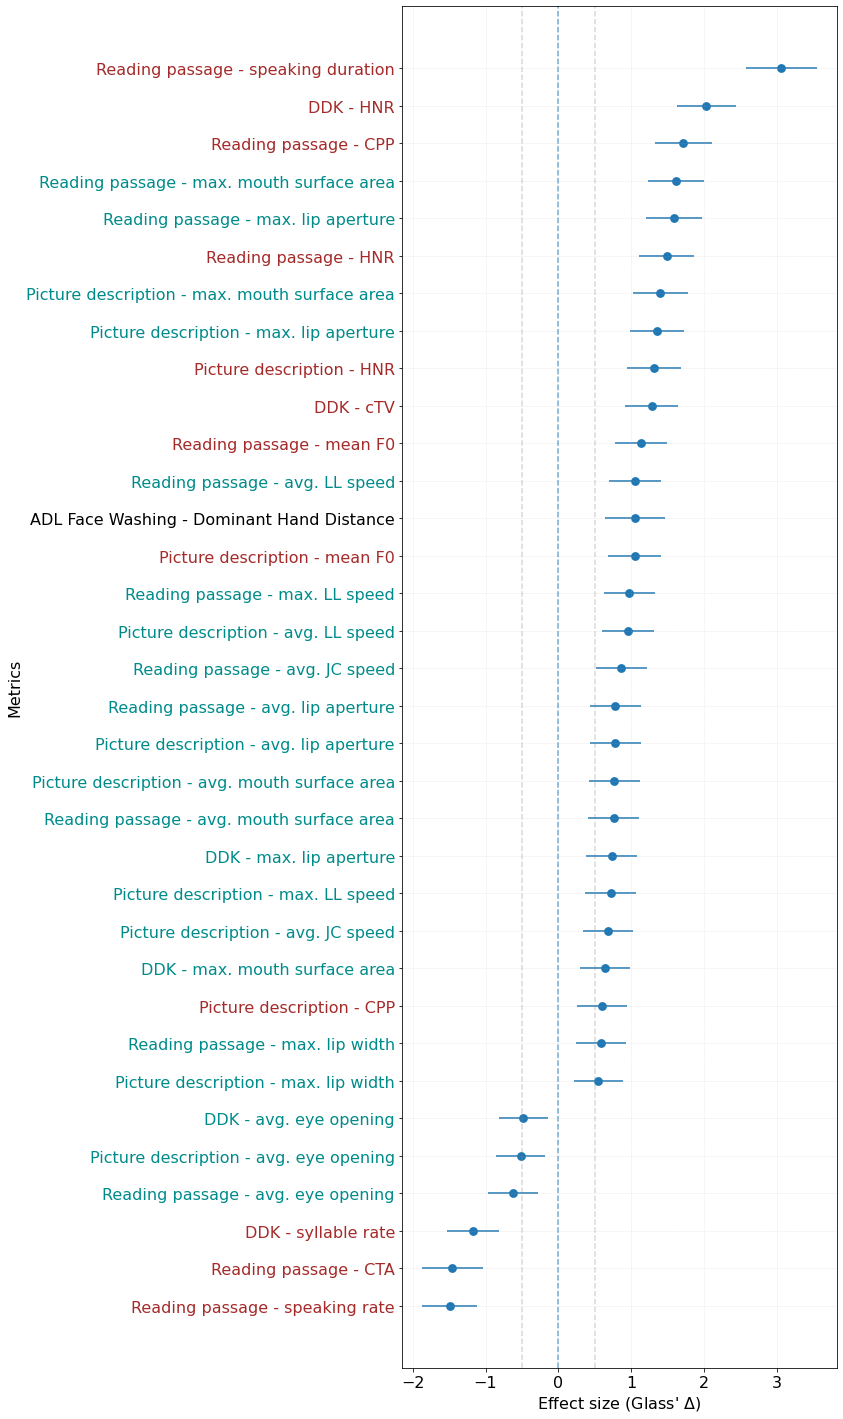

145
Total number of metrics: 145


,label,effect_size,metric,error,p_value,rank,bh_critical,reject_null
0,pALS <> HC,3.063610,speech_metrics_Reading passage - speaking dura...,0.487471,2.148312e-19,1,0.000345,True
1,pALS <> HC,-1.493934,speech_metrics_Reading passage - speaking rate,0.382181,1.179579e-18,2,0.000690,True
2,pALS <> HC,2.032574,speech_metrics_DDK - HNR,0.407217,1.528056e-16,3,0.001034,True
3,pALS <> HC,1.717626,speech_metrics_Reading passage - CPP,0.386892,4.865647e-14,4,0.001379,True
4,pALS <> HC,1.488184,speech_metrics_Reading passage - HNR,0.373677,9.917747e-13,5,0.001724,True
5,pALS <> HC,1.594310,facial_metrics_Reading passage - max. lip aper...,0.383784,3.338445e-12,6,0.002069,True
6,pALS <> HC,1.315192,speech_metrics_Picture description - HNR,0.368715,5.194865e-12,7,0.002414,True
7,pALS <> HC,1.612956,facial_metrics_Reading passage - max. mouth su...,0.384870,1.436030e-11,8,0.002759,True
8,pALS <> HC,1.400120,facial_metrics_Picture description - max. mout...,0.375802,5.597231e-11,9,0.003103,True
9,pALS <> HC,1.358931,facial_metrics_Picture description - max. lip ...,0.373653,4.529016e-10,10,0.003448,True


Positive effects occur when the metric value is larger for the first cohort in the pair


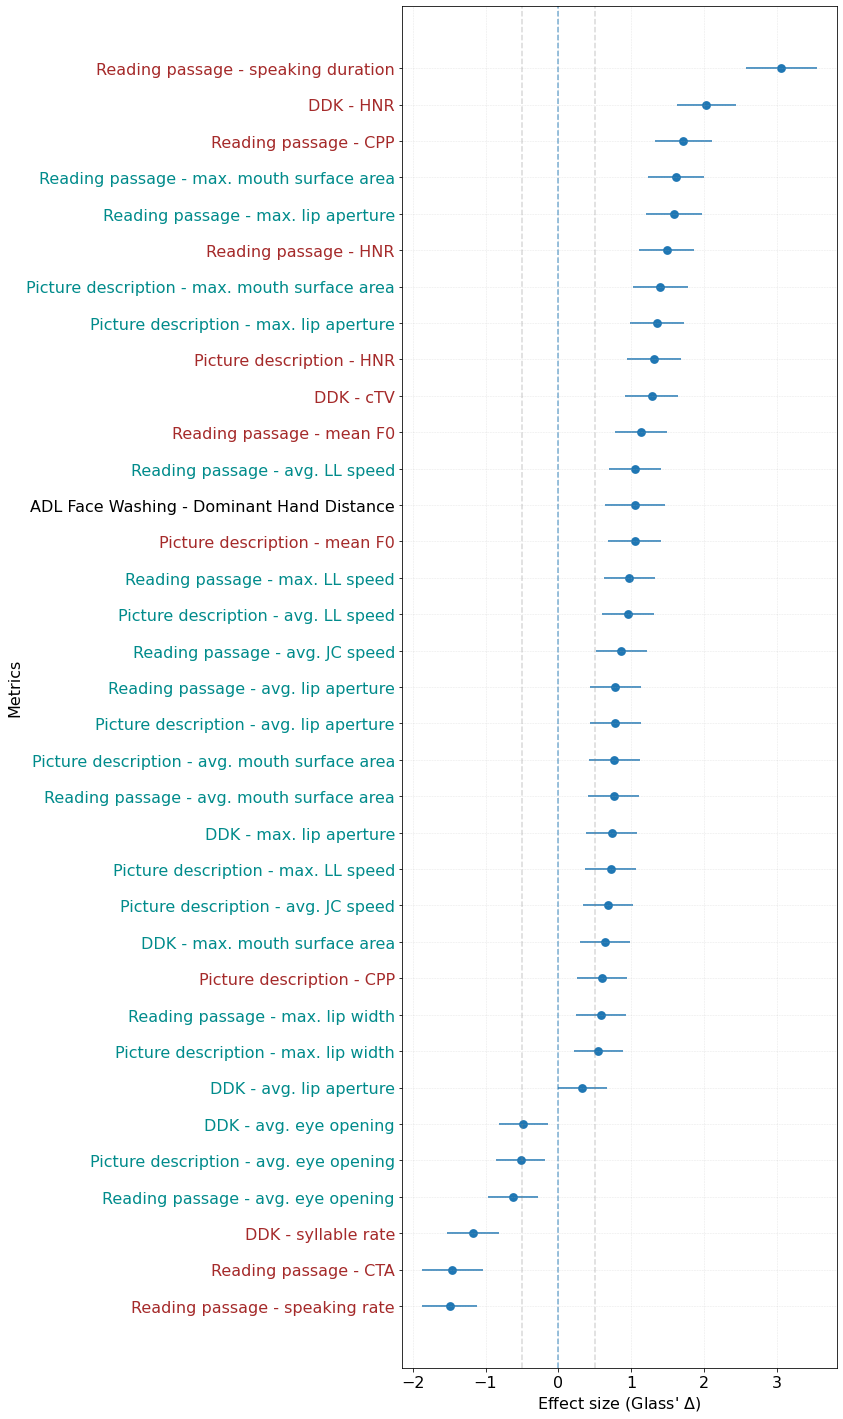

In [ ]:
cohort_mapping = DATA[['demo_cohort', 'demo_cohort_name']].value_counts().index.values
cohort_mapping = {int(k):v for k,v in list(cohort_mapping)}
print(cohort_mapping)

#DATA_X_SECTIONAL = DATA_X_SECTIONAL[DATA_X_SECTIONAL['demo_sex'].isin(['Male', 'Female'])]

p_thresholds = [0.01, 0.05]
FEATURES_WITH_SIGNIFICANT_DIFFERENCES = {}
for p_threshold in p_thresholds:
    effects_all = {'label': [], 'effect_size': [], 'metric': [], 'error': [], 'p_value': []}
    #REGRESSION_TARGET_ALL = dataframe_regr[regression_target_col]
    #dataframe_regr = DATA.dropna(subset=[regression_target_col]).copy()
#    dataframe_for_analysis = utils.zscore_by_sex(
#        DATA_X_SECTIONAL,
#        metrics_prefixes=['speech_metrics_', 'facial_metrics_', 'text_metrics_', 'cognitive_metrics_'],
#        sex_column_label='demo_sex'
#    )
    dataframe_for_analysis = DATA #[DATA['session_info_access_code']!='88d1oq']
    print(len(dataframe_for_analysis))
    metrics = dataframe_for_analysis.filter(regex='ADL|facial_metrics|speech_metrics|text_metrics|cognitive_metrics').columns.to_list()
    metrics = [x for x in metrics if (not 'jerk' in x) and (not 'acceleration' in x) and (not 'graph' in x)]
    num_metrics = len(metrics)
    print(f"Total number of metrics: {num_metrics}")
    df_grouped_by_cohort = dataframe_for_analysis.groupby('demo_cohort')
    num_cohorts = len(dataframe_for_analysis['demo_cohort'].unique())

    for metric in metrics: # this looks at all metrics, alternatively the subset SELECTED_FEATURES_CLUSTERING could be used
        try:
            kruskal_p = stats.kruskal(*[x[metric] for x in [group for _, group in df_grouped_by_cohort]], nan_policy='omit')[1]
        except Exception as e:
            kruskal_p = 1.0
        if kruskal_p < p_threshold:
            #TODO(if num_cohorts==2 the following is an unnecessary repetition of the test)
            # note, for this to work, the 'cohort' column in the dataframe must contain integers starting with 0 (e.g. 0, 1, 2 for three groups)
            for a, b in itertools.combinations(range(num_cohorts), 2):
                group_a_metrics = df_grouped_by_cohort.get_group(a)[metric]
                group_b_metrics = df_grouped_by_cohort.get_group(b)[metric]
                group_a_num_samples = len(group_a_metrics.dropna())
                group_b_num_samples = len(group_b_metrics.dropna())
                if group_a_num_samples < 1 or group_b_num_samples < 1:
                    continue
                kruskal_p = stats.kruskal(
                    group_a_metrics,
                    group_b_metrics,
                    nan_policy='omit')[1]
                if kruskal_p < p_threshold:
                    # be careful with pooled=False, should be used if and only if the second group (group_b) is considered a CONTROL group
                    # in the current setup, the higher-numbered group is always group_b, for example with 3 cohorts we look at the combinations (0, 1), (0, 2), (1, 2)
                    # And only then the measure is called Glass' delta, otherwise it's Cohen's d (see https://en.wikipedia.org/wiki/Effect_size)

                    # from the R documentation ( https://www.rdocumentation.org/packages/effsize/versions/0.8.1/topics/cohen.d ):
                    # pooled: a logical indicating whether compute pooled standard deviation or the whole sample standard deviation.
                    # If pooled=TRUE (default) pooled sd is used, if pooled=FALSE the standard deviation of the the control group (the second argument 
                    # or the one corresponding the the second level of the factor) is used instead.
                    effect_size = cohen_d(robjects.FloatVector(group_a_metrics.dropna()),
                                          robjects.FloatVector(group_b_metrics.dropna()),
                                          pooled=False, within=False)
                    effects_all['label'].append(f'{cohort_mapping[a]} <> {cohort_mapping[b]}')
                    effects_all['effect_size'].append(effect_size[2][0])
                    effects_all['metric'].append(f"{metric}") # ({group_a_num_samples}, {group_b_num_samples})")
                    effects_all['error'].append(np.abs(effect_size[2][0] - np.array(effect_size[4])[0]))
                    effects_all['p_value'].append(kruskal_p)

    df_effsize = pd.DataFrame(effects_all)
    # use the following line to reduce the set of reported metrics by applying some threshold to the effect size value:
    #df_effsize = df_effsize[(df_effsize['effect_size']>=0.3) | (df_effsize['effect_size']<=-0.3)]
    FEATURES_WITH_SIGNIFICANT_DIFFERENCES[p_threshold] = df_effsize['metric'].to_list()
    df_effsize = df_effsize.sort_values(['p_value'], ascending=True).reset_index(drop=True)
    df_effsize['rank'] = df_effsize.index + 1
    df_effsize['bh_critical'] = p_threshold * ((df_effsize['rank']) / num_metrics)
    #display(df_effsize)
    threshold_index = df_effsize[df_effsize['p_value'] <= df_effsize['bh_critical']].last_valid_index()
    if threshold_index is not None:
        cutoff_p = df_effsize.loc[threshold_index, 'p_value']
        df_effsize['reject_null'] = df_effsize['p_value'] <= cutoff_p
    else:
        df_effsize['reject_null'] = False
    df_effsize = df_effsize[df_effsize['reject_null']]
    display(df_effsize)
    print('Positive effects occur when the metric value is larger for the first cohort in the pair')
    df_effsize.sort_values(['effect_size'], ascending=False, inplace=True)
    plt.rcParams.update({'font.size': 16})
    if not df_effsize.empty:
        df_effsize.to_csv(f"{config['DEFAULT']['output_dir']}/effect_sizes_{p_threshold}.csv")
        utils.plot_effect_sizes(
            df_effsize,
            filepath=config['DEFAULT']['output_dir'],
            name_suffix=f'_p{p_threshold}',
            figsize=(12, 20),
            font_colors={'speech_metrics_': 'brown', 'facial_metrics_': 'darkcyan', 'text_metrics_': 'darkblue', 'cognitive_metrics_': 'darkorange'}
        )
    plt.rcParams.update({'font.size': 11})
